In [1]:
import torch.nn as nn
import torch 

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
                 context_length, dropout,
                 num_heads, qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # 1

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out) # 2

        self.dropout = nn.Dropout(dropout) 
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1),
        ) 

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # 3
        queries = self.W_query(x) # 3
        values = self.W_value(x) # 3

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # 4
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2) # 5
        queries = queries.transpose(1, 2) # 5
        values = values.transpose(1, 2) # 5

        attn_scores = queries @ keys.transpose(2, 3) # omega # 6
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # 7

        attn_scores.masked_fill_(mask_bool, -torch.inf) # 8

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2) # 9
        context_vec = context_vec.contiguous().view( # 10
            b, num_tokens, self.d_out
        )

        context_vec = self.out_proj(context_vec) # 11
        return context_vec

In [3]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # layers to train the model
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
                (x + 0.044715 * torch.pow(x, 3))
            )
        )

In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
        # multi-head attention
        self.att = MultiHeadAttention(
            # input dim
            d_in = cfg["emb_dim"],
            # output dim
            d_out = cfg["emb_dim"],
            # actual input length
            context_length = cfg["context_length"],
            # number of causal attention 
            num_heads = cfg["n_heads"],
            # masking rate
            dropout = cfg["drop_rate"],
            # if adding query, key, and value bias
            qkv_bias = cfg["qkv_bias"]
        )

        # Apply layers and activation function to train the model
        self.ff = FeedForward(cfg)

        # normalization
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        
        # masking
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        # 1

        # assgin input as shortcut
        shortcut = x

        # normalize input
        x = self.norm1(x)

        # get context vector
        x = self.att(x)

        # dropout
        x = self.drop_shortcut(x)

        # shortcut: add input to output 
        x = x + shortcut # 2

        # assgin transformed input to shortcut 
        shortcut = x # 3

        # normalizing
        x = self.norm2(x)

        # apply linear layers and activation functions to input
        x = self.ff(x)

        # drop
        x = self.drop_shortcut(x)

        # shortcut: add input to output 
        x = x + shortcut # 4

        return x

In [5]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # create token embeddings
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], cfg["emb_dim"])

        # create positional embeddings
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        # set drop out rate
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Apply transfomer block with n_layers
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # Apply layer normalization to embedding layers
        self.final_norm = LayerNorm(cfg["emb_dim"])

        # create output layers
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        # create token embeddings
        tok_embeds = self.tok_emb(in_idx)

        # create positional embeddings
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device = in_idx.device) # 1
        )
        
        # combine token and positional embeddings
        x = tok_embeds + pos_embeds

        # drop some layers
        x = self.drop_emb(x)

        # apply transformer blocksbb
        x = self.trf_blocks(x)

        # normalizing
        x = self.final_norm(x)

        # apply linear function to x and return probbaility of each token and text
        logits = self.out_head(x)
        
        return logits

## Using GPT to generate text

In [6]:
#1 We shorten the context length from 1,024 to 256 tokens.
#2 It’s possible and common to set dropout to 0.

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,    #1
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,       #2
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): L

In [7]:
def generate_text_simple(model, idx,  # 1
                         max_new_tokens, context_size):
    
    # iterate number of max new tokens provided
    for _ in range(max_new_tokens):

        # extract last number of context size
        idx_cond = idx[:, -context_size:] # 2

        # Disables gradient tracking since we are not training yet
        with torch.no_grad():
            # Obtain logits
            logits = model(idx_cond)

        # only extract the last row from a tensor
        logits = logits[:, -1, :] # 3

        # Obtain probability through softmax
        # Probability of each token in vocabulary
        probas = torch.softmax(logits, dim = -1) # 4
        
        # find the max probability
        idx_next = torch.argmax(probas, dim = -1, keepdim = True) # 5
        
        # find the index corresponding to the max proba
        idx = torch.cat((idx, idx_next), dim = 1) # 6

    return idx

In [8]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    # 1
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    # 2
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

embeddings = text_to_token_ids(start_context, tokenizer)

token_ids = generate_text_simple(
    model = model,
    idx = embeddings,
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))


Output text: 
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## 5.1.2 Calculating the text generation loss

In [9]:
#  targets are the inputs but shifted one position forward

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

In [10]:
#1 Disables gradient tracking since we are not training yet
#2 Probability of each token in vocabulary

with torch.no_grad():     #1
    logits = model(inputs)
    
probas = torch.softmax(logits, dim=-1)     #2
print(probas.shape)


torch.Size([2, 3, 50257])


In [11]:
#1 First batch
#2 Second batch

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [12]:
# The model produces random text 
# that is different from the target text because it has not been trained yet. 

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [13]:
probas

tensor([[[1.8852e-05, 1.5172e-05, 1.1698e-05,  ..., 2.2408e-05,
          6.9822e-06, 1.8781e-05],
         [9.1619e-06, 1.0067e-05, 7.8848e-06,  ..., 2.9088e-05,
          6.0139e-06, 1.3577e-05],
         [2.9887e-05, 8.8599e-06, 1.5754e-05,  ..., 3.5435e-05,
          1.4104e-05, 1.3535e-05]],

        [[1.2571e-05, 2.0535e-05, 1.4342e-05,  ..., 1.0396e-05,
          3.4776e-05, 1.4245e-05],
         [7.2785e-06, 1.7863e-05, 1.0568e-05,  ..., 2.1211e-05,
          1.1390e-05, 1.5565e-05],
         [2.9499e-05, 3.3594e-05, 4.1009e-05,  ..., 6.5304e-06,
          5.8152e-05, 1.3705e-05]]])

In [14]:
# batch: 0
# [0, 1, 2]: extract the first three rows
# targets[0] = [a, b, c] where a, b, c are three indices corresponding to three words

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4514e-05, 3.1054e-05, 1.1567e-05])
Text 2: tensor([1.0343e-05, 5.6737e-05, 4.7620e-06])


## Backpropagation

In [15]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5045, -10.3798, -11.3674, -11.4792,  -9.7771, -12.2549])


In [16]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7938)


In [17]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7938)


## Cross_entropy

In [18]:
print("Logits shape: ", logits.shape)
print("Targets shape: ", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
Targets shape:  torch.Size([2, 3])


In [19]:
# combine batches

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits: ", logits_flat.shape)
print("Flattened targets: ", targets_flat.shape)

Flattened logits:  torch.Size([6, 50257])
Flattened targets:  torch.Size([6])


In [20]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7938)


## Perplexity

In [21]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48717.6914)


## Calculating the training and validation set losses

In [22]:
# load data
file_path = "the-verdict.txt"
with open(file_path, "r", encoding = 'utf-8') as file:
    text_data = file.read()

In [23]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters: ", total_characters)
print("Tokens: ", total_tokens)

Characters:  20479
Tokens:  5145


In [24]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetv1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt) #1
        
        # The stride setting dictates the number of positions the inputs shift across batches, 
        #   emulating a sliding window approach
        for i in range(0, len(token_ids) - max_length, stride): #2
            input_chunk = token_ids[i:i + max_length]
            target_chunck = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunck))
    
    def __len__(self):  #3
        return len(self.input_ids)
    
    def __getitem__(self, idx):     #4
        return self.input_ids[idx], self.target_ids[idx]

In [26]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")                         #1
    dataset = GPTDatasetv1(txt, tokenizer, max_length, stride)   #2
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,     #3
        num_workers=num_workers     #4
    )

    return dataloader

In [27]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = True,
    num_workers = 0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = False,
    shuffle = False,
    num_workers = 0
)

In [28]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [29]:
#1 The transfer to a gievn device allows us to transfer the data to a GPU
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)         #1
    target_batch = target_batch.to(device)      
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [30]:
#1 Iteratives over all batches if no fixed num_batches is specified
#2 Reduces the number of batches to match the total number of batches in the data loader if num_batches exceeds the number of batches in the data loader
#3 Sums loss for each batch
#4 Averages the loss over all batches

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)     #1
    else:
        num_batches = min(num_batches, len(data_loader))   #2
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()    #3
        else:
            break
    return total_loss / num_batches    #4

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device=device)
    val_loss = calc_loss_loader(val_loader, model, device=device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

c:\Users\42128\miniconda3\lib\site-packages\torch\cuda\__init__.py:128: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 1: invalid argument (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Training loss: 10.987384902106392
Validation loss: 10.980905532836914


## Training a LLM

In [32]:
def evaluate_model(model, train_loader, val_loader, 
                   device, eval_iter):
    # 1 Dropout is disabled during evaluation for stable, reproducible results.
    model.eval()
    with torch.no_grad():
        # 2 Disables gradient tracking, which is not required during evaluation, 
        #   to reduce the computational overhead
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches = eval_iter
        )
        
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches = eval_iter
        )
    
    model.train()
    return train_loss, val_loss

In [33]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(model = model, idx = encoded, 
                                         max_new_tokens = 50, context_size = context_size)
        
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    
    # 1 Compact print format
    print(decoded_text.replace("\n", " "))
    model.train()

In [34]:
def train_model_simple(model, train_loader, val_loader, 
                       optimizer, device, num_epochs, 
                       eval_freq, eval_iter, start_context, 
                       tokenizer):
    # 1 Initializes lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 2 Starts the main training loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            # 3 Resets loss gradients from the previous batch iteration
            optimizer.zero_grad()

            # calculate loss value over each batch
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            # 4 Calculates loss gradients
            loss.backward()

            # 5 Updates model weights using loss gradients
            optimizer.step()

            # numel(): returns the total number of elements in the input tensor
            tokens_seen += input_batch.numel()

            global_step += 1

            # 6 Optional evaluation step
            if global_step % eval_freq == 0:

                # evaluate model by trainning loss and validation loss
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                print(f"Ep {epoch + 1} (Step {global_step: 06d}): "
                      f"Train loss {train_loss: .3f}",
                      f"Val loss {val_loss: .3f}")
                
        # 7 Prints a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    
    return train_losses, val_losses, track_tokens_seen

In [35]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    # 1 The .parameters() method returns all trainable weight parameters of the model
    model.parameters(),
    lr = 0.0004, weight_decay = 0.1
)

In [ ]:
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs = num_epochs, eval_freq = 5, eval_iter = 5, 
    start_context = "Every effort moves you", tokenizer = tokenizer
)

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

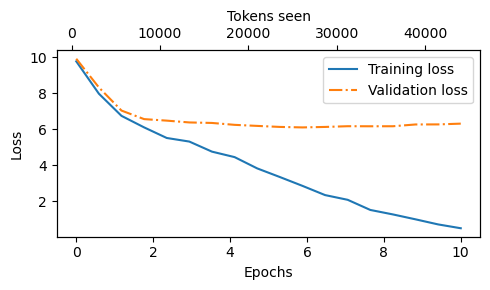

In [45]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    #1 Creates a second x-axis that shares the same y-axis
    ax2 = ax1.twiny()

    #2 Invisible plot for aligning ticks
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Decoding strategies to control randomness

In [37]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): L

In [38]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 25,
    context_size = GPT_CONFIG_124M["context_length"]
)
print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren Mortgage TT remember gard ACTIONSussedOND Land Engeleddedemate breaths proxies GalaxyForm


## Temperature scaling

In [39]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [40]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [41]:
probas = torch.softmax(next_token_logits, dim = 0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [42]:
# To implement a probabilistic sampling process, we can now 
# replace argmax with the multinomial function in PyTorch
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples = 1).item()
print(inverse_vocab[next_token_id])

toward


In [43]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)

    # sample a number from probas for 1000 times
    sample = [torch.multinomial(probas, num_samples = 1).item() 
              for i in range(1000)]
    
    # use binominal distribution to count the unique sample
    sample_ids = torch.bincount(torch.tensor(sample))
    
    for i, freq in enumerate(sample_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [44]:
def softmax_with_temperature(logits, temperature):
    # divide logits by a value greater than 0
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim = 0)

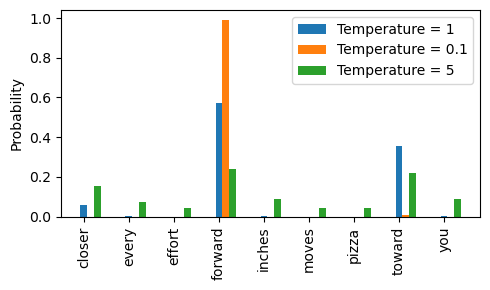

In [45]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], 
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

## 5.3.2 Top-K sampling

In [46]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits: ", top_logits)
print("Top positions: ", top_pos)

Top logits:  tensor([6.7500, 6.2800, 4.5100])
Top positions:  tensor([3, 7, 0])


In [47]:
new_logits =  torch.where(
    # 1 Identifies logits less than the minimum in the top 3
    condition = next_token_logits < top_logits[-1],
    # 2  Assigns –inf to these lower logits
    input = torch.tensor(float("-inf")),
    # 3 Retains the original logits for all other tokens
    other = next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [48]:
tok_probas = torch.softmax(new_logits, dim = 0)
print(tok_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## 5.3.3 Modifying the text generation function

In [49]:
def generate(model, idx, max_new_tokens, context_size,
             temperatures = 0.0, top_k = None, eos_id = None):
    # 1 The for loop is the same as before: gets logits and only focuses on the last time step.
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        
        if top_k is not None:
           # 2 Filters logits with top_k sampling
           top_logits, _ = torch.topk(logits, top_k)
           min_val = top_logits[:, -1]
           logits = torch.where(
               logits < min_val,
               torch.tensor(float("-inf")).to(logits.device),
               logits
           )
        
        if temperatures > 0.0:
            # 3 Applies temperature scaling
            logits = logits / temperatures
            probas = torch.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probas, num_samples = 1)
        else:
            # 4 Carries out greedy next-token selection as before when temperature scaling is disabled
            idx_next = torch.argmax(logits, dim = -1, keepdim = True)
        
        # 5 Stops generating early if end-of-sequence token is encountered
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim = 1)
    
    return idx

In [50]:
torch.manual_seed(123)
token_ids = generate(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M["context_length"],
    top_k = 25,
    temperatures = 1.4
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you inferred rolleduint fabricationagos remarkably hereuced saints freewaylookOkayRand salary baseless


In [51]:
token_ids = generate(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M["context_length"],
    top_k = 10,
    temperatures = 0.5
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you Samoa Committees *) bicycle109urban poisonous Alexandacha ENG Ornlashoof battling principally


## 5.4 Loading and saving model weights in PyTorch

In [68]:
torch.save(model.state_dict(), "model.path")

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.path", map_location = device))

# we don’t want to randomly drop out any of the information the network has learned. 
# Using model.eval() switches the model to evaluation mode for inference, 
# disabling the dropout layers of the model.
model.eval()

C:\Users\42128\AppData\Local\Temp\ipykernel_27656\2709282499.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.path", map_location 

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): L

In [74]:
# save both model and optimizer
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.path"
)

In [52]:
optimizer.load_state_dict(torch.load("model_and_optimizer.path")["optimizer_state_dict"])
model.load_state_dict(torch.load("model_and_optimizer.path")["model_state_dict"])

C:\Users\42128\AppData\Local\Temp\ipykernel_30200\1162813105.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimizer.load_state_dict(torch.load("model_and_optimizer.pa

<All keys matched successfully>

In [53]:
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): L

## Loading pretrained weights from OpenAI

In [54]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x1b38c653a60>)

In [55]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size = "124M",
    models_dir = "gpt2"
)

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [56]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [59]:
# wte: token embedding weight
print(params["wte"])

print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [58]:
# Model configuration

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [60]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [61]:
NEW_CONFIG.update({"context_length": 1024})

In [62]:
NEW_CONFIG.update({"qkv_bias": True})

In [63]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Lin

In [64]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                         "Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [67]:
import numpy as np

def load_weights_into_gpt(gpt, params):           
    #1 Sets the model’s positional and token embedding weights to those specified in params.
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    #2 Iterates over each transformer block in the model
    for b in range(len(params["blocks"])):

        #3 The np.split function is used to divide the attention and bias weights into 
        # three equal parts for the query, key, and value components.

        # attention weights
        q_w, k_w, v_w = np.split(                            
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # bias weights
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        # weight tensor for the output projection layer
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        # weight and bias from layers
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        # normalizing 
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    #4 he original GPT-2 model by OpenAI reused the token embedding weights in the output layer to 
    # reduce the total number of parameters, which is a concept known as weight tying.
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [68]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Lin

In [69]:
torch.manual_seed(123)
token_ids = generate(
    model = gpt,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens = 25,
    context_size = NEW_CONFIG["context_length"],
    top_k = 50,
    temperatures = 1.5
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the


### Calculate the training and validation set losses of the GPTModel with the pretrained weights from OpenAI on the “The Verdict” dataset.

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)

# train loader is using the verdict data
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, gpt, device=device)
    val_loss = calc_loss_loader(val_loader, gpt, device=device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.7546131345960827
Validation loss: 3.5596015453338623


### Experiment with GPT-2 models of different sizes—for example, the largest 1,558 million parameter model—and compare the generated text to the 124 million model.

In [72]:
NEW_CONFIG.update(model_configs["gpt2-xl (1558M)"])
gpt_large = GPTModel(NEW_CONFIG)
gpt_large.eval()

GPTModel(
  (tok_emb): Embedding(50257, 1600, padding_idx=1600)
  (pos_emb): Embedding(1024, 1600)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1600, out_features=1600, bias=True)
        (W_key): Linear(in_features=1600, out_features=1600, bias=True)
        (W_value): Linear(in_features=1600, out_features=1600, bias=True)
        (out_proj): Linear(in_features=1600, out_features=1600, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1600, out_features=6400, bias=True)
          (1): GELU()
          (2): Linear(in_features=6400, out_features=1600, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (

In [73]:
torch.manual_seed(123)
token_ids = generate(
    model = gpt_large,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens = 25,
    context_size = NEW_CONFIG["context_length"],
    top_k = 50,
    temperatures = 1.5
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you mocking timestamp Scholarship Stories marshroeOM Equ therm Lawsmb passports convince647mob overdueaningcalaughty licencesYou painting serotoninmediamb
